In [22]:
import torch
from torch import nn

import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [28]:
# Additional Hyper-Parameters
RANDOM_SEED       = 42
BATCH_SIZE        = 512
EPOCHS            = 40

LEARNING_RATE     = 1e-4
NUM_CLASSES       = 10
PATCH_SIZE        = 4
IMG_SIZE          = 28
IN_CHANNELS       = 1
NUM_HEADS         = 8 # No. of Attention Heads
DROPOUT           = 0.001
HIDDEN_DIM        = 768 # Hidden dim of MLP head
ADAM_WEIGHT_DECAY = 0 # Default 0, can use 0.1 also
ADAM_BETAS        = (0.9, 0.999)
ACTIVATION        = "gelu"
NUM_ENCODERS      = 4
EMBED_DIM         = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES       = (IMG_SIZE // PATCH_SIZE)  ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        """ 
        patcher takes an image, divides it into square of patch_sizes and flattens it
         """
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = embed_dim,
                kernel_size = patch_size,
                stride = patch_size
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad = True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim = 1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [20]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, 
                                                   nhead=num_heads, 
                                                   dropout=dropout, 
                                                   activation=activation, 
                                                   batch_first=True,
                                                   norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 10])


In [36]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [37]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [42]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indices):
        self.images    = images
        self.labels    = labels
        self.indices   = indices
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}


class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indices = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

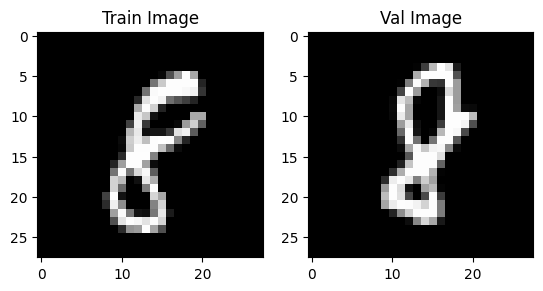

In [45]:
plt.figure()
f, axarr = plt.subplots(1, 2)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

In [46]:
train_dataloader = DataLoader(
    dataset    = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle    = True
)

val_dataloader = DataLoader(
    dataset    = val_dataset,
    batch_size = BATCH_SIZE,
    shuffle    = True
)

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.73it/s]


------------------------------
Train Loss EPOCH 1: 2.0842
Valid Loss EPOCH 1: 1.7999


  2%|██                                                                                 | 1/40 [00:19<12:28, 19.19s/it]

Train Accuracy EPOCH 1: 0.2522
Valid Accuracy EPOCH 1: 0.3793
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.70it/s]


------------------------------
Train Loss EPOCH 2: 1.6966
Valid Loss EPOCH 2: 1.5014


  5%|████▏                                                                              | 2/40 [00:38<12:11, 19.25s/it]

Train Accuracy EPOCH 2: 0.4468
Valid Accuracy EPOCH 2: 0.5374
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.64it/s]


------------------------------
Train Loss EPOCH 3: 1.5036
Valid Loss EPOCH 3: 1.3392


  8%|██████▏                                                                            | 3/40 [01:01<12:47, 20.75s/it]

Train Accuracy EPOCH 3: 0.5460
Valid Accuracy EPOCH 3: 0.6300
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.54it/s]


------------------------------
Train Loss EPOCH 4: 1.3841
Valid Loss EPOCH 4: 1.2391


 10%|████████▎                                                                          | 4/40 [01:26<13:32, 22.57s/it]

Train Accuracy EPOCH 4: 0.6012
Valid Accuracy EPOCH 4: 0.6686
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.73it/s]


------------------------------
Train Loss EPOCH 5: 1.2920
Valid Loss EPOCH 5: 1.1182


 12%|██████████▍                                                                        | 5/40 [01:48<13:09, 22.56s/it]

Train Accuracy EPOCH 5: 0.6370
Valid Accuracy EPOCH 5: 0.7257
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.37it/s]


------------------------------
Train Loss EPOCH 6: 1.2095
Valid Loss EPOCH 6: 1.0619


 15%|████████████▍                                                                      | 6/40 [02:09<12:22, 21.84s/it]

Train Accuracy EPOCH 6: 0.6648
Valid Accuracy EPOCH 6: 0.7340
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.89it/s]


------------------------------
Train Loss EPOCH 7: 1.1459
Valid Loss EPOCH 7: 1.0122


 18%|██████████████▌                                                                    | 7/40 [02:30<11:51, 21.57s/it]

Train Accuracy EPOCH 7: 0.6878
Valid Accuracy EPOCH 7: 0.7579
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.20it/s]


------------------------------
Train Loss EPOCH 8: 1.0673
Valid Loss EPOCH 8: 0.9414


 20%|████████████████▌                                                                  | 8/40 [02:53<11:48, 22.15s/it]

Train Accuracy EPOCH 8: 0.7192
Valid Accuracy EPOCH 8: 0.7681
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.68it/s]


------------------------------
Train Loss EPOCH 9: 1.0124
Valid Loss EPOCH 9: 0.8707


 22%|██████████████████▋                                                                | 9/40 [03:17<11:45, 22.75s/it]

Train Accuracy EPOCH 9: 0.7328
Valid Accuracy EPOCH 9: 0.7931
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.13it/s]


------------------------------
Train Loss EPOCH 10: 0.9456
Valid Loss EPOCH 10: 0.8317


 25%|████████████████████▌                                                             | 10/40 [03:42<11:36, 23.21s/it]

Train Accuracy EPOCH 10: 0.7541
Valid Accuracy EPOCH 10: 0.8057
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.95it/s]


------------------------------
Train Loss EPOCH 11: 0.8962
Valid Loss EPOCH 11: 0.7872


 28%|██████████████████████▌                                                           | 11/40 [04:06<11:22, 23.53s/it]

Train Accuracy EPOCH 11: 0.7688
Valid Accuracy EPOCH 11: 0.8107
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.82it/s]


------------------------------
Train Loss EPOCH 12: 0.8432
Valid Loss EPOCH 12: 0.6932


 30%|████████████████████████▌                                                         | 12/40 [04:30<11:07, 23.84s/it]

Train Accuracy EPOCH 12: 0.7839
Valid Accuracy EPOCH 12: 0.8362
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.89it/s]


------------------------------
Train Loss EPOCH 13: 0.7994
Valid Loss EPOCH 13: 0.6755


 32%|██████████████████████████▋                                                       | 13/40 [04:55<10:51, 24.12s/it]

Train Accuracy EPOCH 13: 0.7942
Valid Accuracy EPOCH 13: 0.8460
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.89it/s]


------------------------------
Train Loss EPOCH 14: 0.7495
Valid Loss EPOCH 14: 0.6089


 35%|████████████████████████████▋                                                     | 14/40 [05:20<10:30, 24.25s/it]

Train Accuracy EPOCH 14: 0.8082
Valid Accuracy EPOCH 14: 0.8652
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.13it/s]


------------------------------
Train Loss EPOCH 15: 0.7192
Valid Loss EPOCH 15: 0.5622


 38%|██████████████████████████████▊                                                   | 15/40 [05:41<09:43, 23.34s/it]

Train Accuracy EPOCH 15: 0.8131
Valid Accuracy EPOCH 15: 0.8733
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.82it/s]


------------------------------
Train Loss EPOCH 16: 0.6784
Valid Loss EPOCH 16: 0.5560


 40%|████████████████████████████████▊                                                 | 16/40 [06:02<09:05, 22.73s/it]

Train Accuracy EPOCH 16: 0.8239
Valid Accuracy EPOCH 16: 0.8712
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.10it/s]


------------------------------
Train Loss EPOCH 17: 0.6618
Valid Loss EPOCH 17: 0.5023


 42%|██████████████████████████████████▊                                               | 17/40 [06:26<08:51, 23.12s/it]

Train Accuracy EPOCH 17: 0.8248
Valid Accuracy EPOCH 17: 0.8871
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.85it/s]


------------------------------
Train Loss EPOCH 18: 0.6101
Valid Loss EPOCH 18: 0.5097


 45%|████████████████████████████████████▉                                             | 18/40 [06:49<08:25, 22.99s/it]

Train Accuracy EPOCH 18: 0.8406
Valid Accuracy EPOCH 18: 0.8800
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.03it/s]


------------------------------
Train Loss EPOCH 19: 0.5790
Valid Loss EPOCH 19: 0.4677


 48%|██████████████████████████████████████▉                                           | 19/40 [07:09<07:46, 22.21s/it]

Train Accuracy EPOCH 19: 0.8493
Valid Accuracy EPOCH 19: 0.8964
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.65it/s]


------------------------------
Train Loss EPOCH 20: 0.5595
Valid Loss EPOCH 20: 0.4332


 50%|█████████████████████████████████████████                                         | 20/40 [07:30<07:13, 21.70s/it]

Train Accuracy EPOCH 20: 0.8527
Valid Accuracy EPOCH 20: 0.8986
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.83it/s]


------------------------------
Train Loss EPOCH 21: 0.5453
Valid Loss EPOCH 21: 0.4223


 52%|███████████████████████████████████████████                                       | 21/40 [07:50<06:45, 21.34s/it]

Train Accuracy EPOCH 21: 0.8555
Valid Accuracy EPOCH 21: 0.9071
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.04it/s]


------------------------------
Train Loss EPOCH 22: 0.5162
Valid Loss EPOCH 22: 0.4028


 55%|█████████████████████████████████████████████                                     | 22/40 [08:11<06:19, 21.08s/it]

Train Accuracy EPOCH 22: 0.8630
Valid Accuracy EPOCH 22: 0.9045
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.04it/s]


------------------------------
Train Loss EPOCH 23: 0.4893
Valid Loss EPOCH 23: 0.3769


 57%|███████████████████████████████████████████████▏                                  | 23/40 [08:31<05:55, 20.89s/it]

Train Accuracy EPOCH 23: 0.8699
Valid Accuracy EPOCH 23: 0.9093
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.03it/s]


------------------------------
Train Loss EPOCH 24: 0.4779
Valid Loss EPOCH 24: 0.3652


 60%|█████████████████████████████████████████████████▏                                | 24/40 [08:52<05:32, 20.80s/it]

Train Accuracy EPOCH 24: 0.8719
Valid Accuracy EPOCH 24: 0.9152
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.98it/s]


------------------------------
Train Loss EPOCH 25: 0.4658
Valid Loss EPOCH 25: 0.3601


 62%|███████████████████████████████████████████████████▎                              | 25/40 [09:13<05:14, 20.93s/it]

Train Accuracy EPOCH 25: 0.8726
Valid Accuracy EPOCH 25: 0.9121
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.83it/s]


------------------------------
Train Loss EPOCH 26: 0.4467
Valid Loss EPOCH 26: 0.3398


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [09:34<04:50, 20.78s/it]

Train Accuracy EPOCH 26: 0.8794
Valid Accuracy EPOCH 26: 0.9162
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.04it/s]


------------------------------
Train Loss EPOCH 27: 0.4299
Valid Loss EPOCH 27: 0.3350


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [09:54<04:29, 20.71s/it]

Train Accuracy EPOCH 27: 0.8826
Valid Accuracy EPOCH 27: 0.9205
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.81it/s]


------------------------------
Train Loss EPOCH 28: 0.4167
Valid Loss EPOCH 28: 0.3123


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [10:14<04:07, 20.61s/it]

Train Accuracy EPOCH 28: 0.8852
Valid Accuracy EPOCH 28: 0.9245
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.03it/s]


------------------------------
Train Loss EPOCH 29: 0.4008
Valid Loss EPOCH 29: 0.3330


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [10:35<03:46, 20.55s/it]

Train Accuracy EPOCH 29: 0.8901
Valid Accuracy EPOCH 29: 0.9186
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.94it/s]


------------------------------
Train Loss EPOCH 30: 0.4001
Valid Loss EPOCH 30: 0.2896


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [10:55<03:24, 20.47s/it]

Train Accuracy EPOCH 30: 0.8900
Valid Accuracy EPOCH 30: 0.9276
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.83it/s]


------------------------------
Train Loss EPOCH 31: 0.3809
Valid Loss EPOCH 31: 0.2991


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [11:16<03:06, 20.67s/it]

Train Accuracy EPOCH 31: 0.8953
Valid Accuracy EPOCH 31: 0.9250
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.63it/s]


------------------------------
Train Loss EPOCH 32: 0.3679
Valid Loss EPOCH 32: 0.2685


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [11:37<02:45, 20.66s/it]

Train Accuracy EPOCH 32: 0.8984
Valid Accuracy EPOCH 32: 0.9305
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.60it/s]


------------------------------
Train Loss EPOCH 33: 0.3618
Valid Loss EPOCH 33: 0.3209


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [11:58<02:25, 20.80s/it]

Train Accuracy EPOCH 33: 0.8990
Valid Accuracy EPOCH 33: 0.9088
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.71it/s]


------------------------------
Train Loss EPOCH 34: 0.3537
Valid Loss EPOCH 34: 0.2546


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [12:19<02:04, 20.78s/it]

Train Accuracy EPOCH 34: 0.9012
Valid Accuracy EPOCH 34: 0.9324
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.28it/s]


------------------------------
Train Loss EPOCH 35: 0.3415
Valid Loss EPOCH 35: 0.2677


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [12:40<01:45, 21.01s/it]

Train Accuracy EPOCH 35: 0.9026
Valid Accuracy EPOCH 35: 0.9288
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.73it/s]


------------------------------
Train Loss EPOCH 36: 0.3265
Valid Loss EPOCH 36: 0.2567


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [13:02<01:24, 21.25s/it]

Train Accuracy EPOCH 36: 0.9070
Valid Accuracy EPOCH 36: 0.9336
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.06it/s]


------------------------------
Train Loss EPOCH 37: 0.3234
Valid Loss EPOCH 37: 0.2464


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [13:23<01:03, 21.12s/it]

Train Accuracy EPOCH 37: 0.9073
Valid Accuracy EPOCH 37: 0.9367
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.59it/s]


------------------------------
Train Loss EPOCH 38: 0.3154
Valid Loss EPOCH 38: 0.2589


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [13:44<00:42, 21.16s/it]

Train Accuracy EPOCH 38: 0.9100
Valid Accuracy EPOCH 38: 0.9295
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.25it/s]


------------------------------
Train Loss EPOCH 39: 0.3097
Valid Loss EPOCH 39: 0.2328


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [14:06<00:21, 21.41s/it]

Train Accuracy EPOCH 39: 0.9098
Valid Accuracy EPOCH 39: 0.9371
------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.74it/s]


------------------------------
Train Loss EPOCH 40: 0.3071
Valid Loss EPOCH 40: 0.2197


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:31<00:00, 21.80s/it]

Train Accuracy EPOCH 40: 0.9129
Valid Accuracy EPOCH 40: 0.9395
------------------------------
Training Time: 871.86s


In [50]:
torch.cuda.empty_cache()

In [53]:
labels = []
imgs = []
model.eval()

with torch.no_grad():
    for idx, sample in enumerate(tqdm(val_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.42it/s]
